### OLS Regression Trading Strategy ###

Implementation of Ernie Chans OLS regression algorithm as described in his book Algorithmic Trading.

Build out of functions and optimiser to backtest multiple strategies at once. 

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts

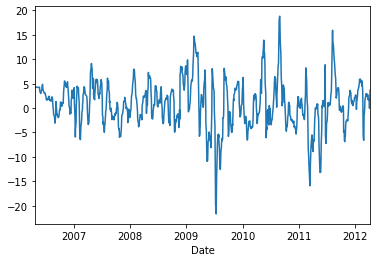

In [4]:
df=pd.read_csv('inputData_GLD_USO.csv')
df['Date']=pd.to_datetime(df['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df.set_index('Date', inplace=True)

lookback=20
hedgeRatio=np.full(df.shape[0], np.nan)
for t in np.arange(lookback, len(hedgeRatio)):
    regress_results=sm.ols(formula="USO ~ GLD", data=np.log(df[(t-lookback):t])).fit() # Note this can deal with NaN in top row
    hedgeRatio[t-1]=regress_results.params[1]

yport=np.sum(ts.add_constant(-hedgeRatio)[:, [1,0]]*np.log(df), axis=1)
yport.plot()

APR=0.099520 Sharpe=0.553442


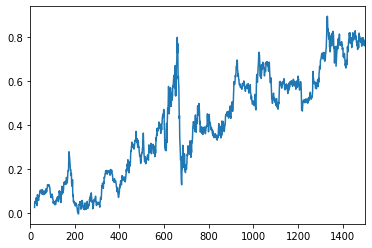

In [3]:
# Apply a simple linear mean reversion strategy to GLD-USO
numUnits =-(yport-yport.rolling(lookback).mean())/yport.rolling(lookback).std() # capital invested in portfolio in dollars.  movingAvg and movingStd are functions from epchan.com/book2
positions=pd.DataFrame(np.tile(numUnits.values, [2, 1]).T * ts.add_constant(-hedgeRatio)[:, [1,0]] ) #  positions is the dollar capital in each ETF.
pnl=np.sum((positions.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(positions.shift()), axis=1)
(np.cumprod(1+ret)-1).plot()
print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))

In [6]:
asx_200 = pd.read_csv('ASX_200_daily.csv', index_col = 0, parse_dates =True)

xjo_cba = asx_200[['XJO', 'CBA']]

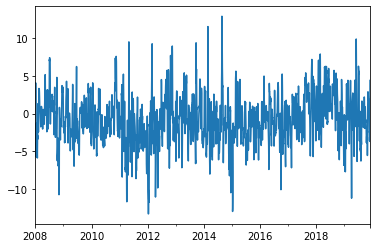

In [15]:
lookback=10
hedgeRatio=np.full(xjo_cba.shape[0], np.nan)
for t in np.arange(lookback, len(hedgeRatio)):
    regress_results=sm.ols(formula="XJO ~ CBA", data=np.log(xjo_cba[(t-lookback):t])).fit() # Note this can deal with NaN in top row
    hedgeRatio[t-1]=regress_results.params[1]

yport=np.sum(ts.add_constant(-hedgeRatio)[:, [1,0]]*np.log(xjo_cba), axis=1)
yport.plot()

APR=-0.023963 Sharpe=-0.119766


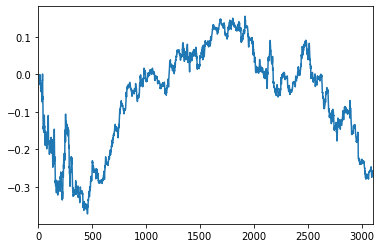

In [16]:
# Apply a simple linear mean reversion strategy to GLD-USO
numUnits =-(yport-yport.rolling(lookback).mean())/yport.rolling(lookback).std() # capital invested in portfolio in dollars.  movingAvg and movingStd are functions from epchan.com/book2
positions=pd.DataFrame(np.tile(numUnits.values, [2, 1]).T * ts.add_constant(-hedgeRatio)[:, [1,0]] ) #  positions is the dollar capital in each ETF.
pnl=np.sum((positions.shift().values)*(xjo_cba.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(positions.shift()), axis=1)
(np.cumprod(1+ret)-1).plot()
print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))

In [28]:
def hedge_ratio(df, symbol_1, symbol_2, lookback, plot = False):
    
    hedgeRatio=np.full(df.shape[0], np.nan)
    
    formula_string = str(symbol_1) + ' ~ ' + str(symbol_2)
    for t in np.arange(lookback, len(hedgeRatio)):
        regress_results=sm.ols(formula=formula_string, data=np.log(df[(t-lookback):t])).fit() # Note this can deal with NaN in top row
        hedgeRatio[t-1]=regress_results.params[1]

    yport=np.sum(ts.add_constant(-hedgeRatio)[:, [1,0]]*np.log(df), axis=1)

    numUnits =-(yport-yport.rolling(lookback).mean())/yport.rolling(lookback).std() # capital invested in portfolio in dollars.  movingAvg and movingStd are functions from epchan.com/book2
    positions=pd.DataFrame(np.tile(numUnits.values, [2, 1]).T * ts.add_constant(-hedgeRatio)[:, [1,0]] ) #  positions is the dollar capital in each ETF.
    pnl=np.sum((positions.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
    ret=pnl/np.sum(np.abs(positions.shift()), axis=1)
    if plot == True:
        (np.cumprod(1+ret)-1).plot()
        
    APR, Sharpe = np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)
    
    return APR, Sharpe
    

def hedge_ratio_optimiser(full_df, symbol_1, symbol_2, lookback_array):
    
    df = full_df[[symbol_1, symbol_2]].dropna()
    results = pd.DataFrame()
    for lookback in lookback_array:
        APR, Sharpe = hedge_ratio(df, symbol_1, symbol_2, lookback)
        results = results.append(pd.DataFrame(
            {'Lookback': lookback,
             'APR': APR,
             'Sharpe': Sharpe} ,index=[0]), ignore_index=True)
        
    return results 

In [26]:
symbol_1 = 'XJO'
symbol_2 = 'CBA'

str(symbol_1) + ' ~ ' + str(symbol_2)
asx_200

,XJO,CBA,CSL,BHP,WBC,NAB,ANZ,WOW,MQG,WES,...,MYX,WSA,OML,SXL,EHE,HUB,PLS,ORE,GXY,SDA
2008-01-01,6339.836,58.846,36.36,36.367,27.603,35.923,27.46,33.658,74.935,26.770,...,0.2986,5.45,NaN,3.0954,NaN,5.9926,0.300,0.2411,1.8203,NaN
2008-01-02,6353.162,58.547,36.57,36.512,27.741,35.629,27.57,33.668,75.722,26.935,...,0.2986,5.57,NaN,3.1104,NaN,5.9926,0.300,0.2226,1.8203,NaN
2008-01-03,6290.713,57.502,36.50,36.331,27.277,35.125,27.33,33.371,72.477,27.067,...,0.3092,5.55,NaN,3.0954,NaN,5.6772,0.325,0.2226,1.7100,NaN
2008-01-04,6306.817,57.790,35.49,37.010,27.326,35.486,27.41,33.321,71.985,26.948,...,0.3092,5.66,NaN,3.0804,NaN,5.6772,0.375,0.2411,1.8203,NaN
2008-01-07,6161.624,56.954,34.50,36.258,26.842,34.507,26.69,32.856,70.205,26.446,...,0.3092,5.40,NaN,2.9680,NaN,5.6772,0.325,0.2318,1.8479,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-26,6787.530,80.740,279.73,37.900,24.860,26.150,24.94,39.180,136.300,41.780,...,0.4500,2.90,2.96,0.9250,2.73,11.1600,0.305,2.6500,0.9650,0.855
2019-11-27,6850.601,81.690,279.99,38.350,24.810,26.180,25.06,39.680,137.360,42.400,...,0.4450,2.93,3.01,0.9300,2.70,11.3000,0.300,2.5700,0.9800,0.825
2019-11-28,6863.998,81.600,282.99,38.500,24.700,26.180,24.87,39.650,138.050,42.410,...,0.4400,2.91,3.06,0.9250,2.71,11.1800,0.300,2.5700,0.9450,0.810
2019-11-29,6845.996,80.820,283.48,38.230,24.520,25.890,24.84,39.760,138.050,42.370,...,0.4650,2.78,3.13,0.9600,2.69,10.8600,0.300,2.5200,0.9250,0.810


In [24]:
hedge_ratio(xjo_cba, 'XJO', 'CBA', 5y, plot = True)

(0.06237169438461354, 0.5210248765507238)

In [30]:
hedge_ratio_optimiser(asx_200, 'NAB', 'ANZ', [5,10,15,20,50])

,Lookback,APR,Sharpe
0,5,0.032186,0.324651
1,10,0.025206,0.275341
2,15,0.006848,0.117688
3,20,0.025325,0.291994
4,50,-0.018695,-0.140049


(0.03218616573339905, 0.3246510666083455)

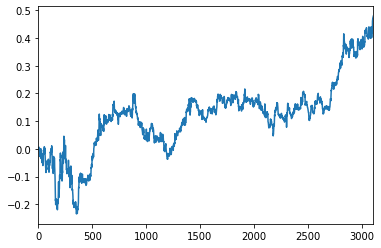

In [31]:
df_nab_anz = asx_200[['NAB', 'ANZ']].dropna()
hedge_ratio(df_nab_anz, 'NAB', 'ANZ', 5, plot = True)

In [33]:
hedge_ratio_optimiser(df, 'GLD', 'USO', [5,10,15,20,50,75])

,Lookback,APR,Sharpe
0,5,-0.067806,-0.111199
1,10,0.127444,0.566666
2,15,0.057411,0.341050
3,20,0.098379,0.476836
4,50,-0.130827,-0.355366
5,75,-0.038961,0.007514


In [34]:
hedge_ratio_optimiser(df, 'GLD', 'USO', [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])

,Lookback,APR,Sharpe
0,5,-0.067806,-0.111199
1,6,-0.191570,-0.611849
2,7,-0.187385,-0.592574
3,8,-0.178425,-0.546853
4,9,0.077185,0.404388
5,10,0.127444,0.566666
6,11,0.045684,0.301086
7,12,0.223886,0.861108
8,13,0.216621,0.842779
9,14,0.114477,0.529492


(0.22388593723390526, 0.8611075988596478)

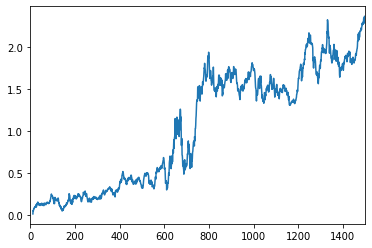

In [41]:
hedge_ratio(df, 'GLD', 'USO', 12, True)

In [42]:
hedge_ratio_optimiser(asx_200, 'CSL', 'COH', [5,10,15,20,50])

,Lookback,APR,Sharpe
0,5,-0.047953,-0.150841
1,10,-0.104218,-0.454225
2,15,-0.052877,-0.179087
3,20,-0.022055,-0.016366
4,50,0.063046,0.411296


(0.06304562119862456, 0.4112964433579568)

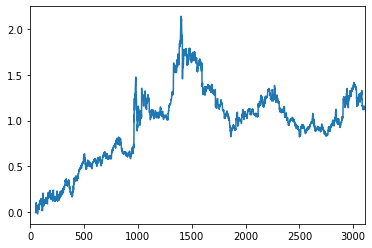

In [43]:
df_nab_anz = asx_200[['CSL', 'COH']].dropna()
hedge_ratio(df_nab_anz, 'CSL', 'COH', 50, plot = True)